#### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [3]:
import time
import os
import pandas as pd

project_name = 'Digit_Recognizer'
step_name = 'Train'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

cwd = os.getcwd()
model_path = os.path.join(cwd, 'model')
print('model_path: ' + model_path)

run_name: Digit_Recognizer_Train_20171025_113520
model_path: E:\Kaggle\Digit_Recognizer\model


In [4]:
train_file = ".\\input\\train.csv"
test_file = ".\\input\\test.csv"
output_file = ".\\output\\submission.csv"

In [5]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

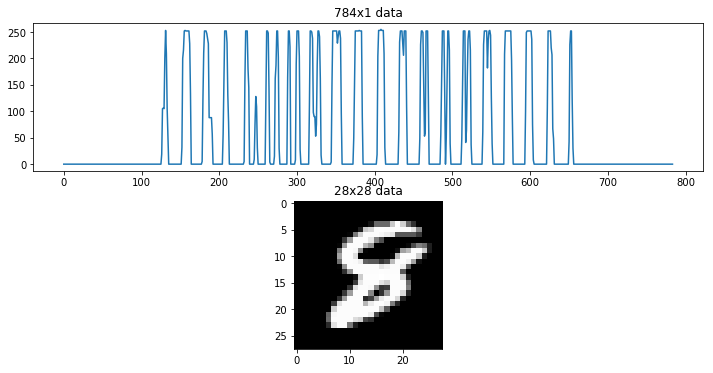

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

(37800, 784)
(37800, 28, 28, 1)
(28, 28, 1)


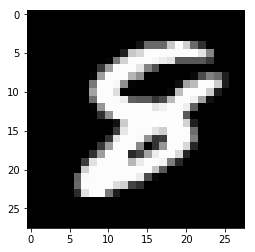

In [7]:
print(x_train.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_train[0].shape)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [8]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [9]:
print(y_train[0])
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

8
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [10]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [11]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [13]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(model_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:E:\Kaggle\Digit_Recognizer\model\Digit_Recognizer_Train_20171025_113520


In [14]:
%%time
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1024, seed=2017),
                           steps_per_epoch=500,
                           epochs=30, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer, tensorBoard])

Epoch 1/30
500/500 [==============================] - 120s - loss: 0.4761 - acc: 0.8491 - val_loss: 0.5567 - val_acc: 0.8725
Epoch 2/30
500/500 [==============================] - 116s - loss: 0.1108 - acc: 0.9687 - val_loss: 0.0629 - val_acc: 0.9850
Epoch 3/30
500/500 [==============================] - 111s - loss: 0.0786 - acc: 0.9776 - val_loss: 0.0505 - val_acc: 0.9775
Epoch 4/30
500/500 [==============================] - 111s - loss: 0.0654 - acc: 0.9814 - val_loss: 0.0363 - val_acc: 0.9825
Epoch 5/30
500/500 [==============================] - 114s - loss: 0.0559 - acc: 0.9843 - val_loss: 0.0426 - val_acc: 0.9850
Epoch 6/30
500/500 [==============================] - 117s - loss: 0.0500 - acc: 0.9856 - val_loss: 0.0458 - val_acc: 0.9850
Epoch 7/30
500/500 [==============================] - 115s - loss: 0.0455 - acc: 0.9868 - val_loss: 0.0445 - val_acc: 0.9875
Epoch 8/30
500/500 [==============================] - 113s - loss: 0.0426 - acc: 0.9875 - val_loss: 0.0413 - val_acc: 0.9900


In [15]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0134, final accuracy: 0.9960


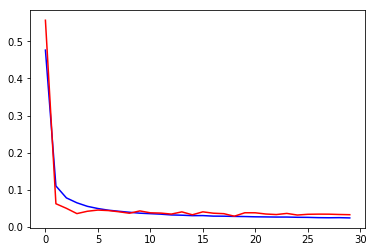

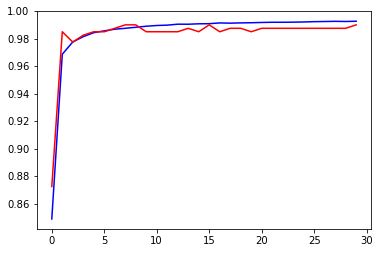

In [16]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [17]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[441   0   0   0   0   1   0   0   0   0]
 [  0 462   0   0   0   0   0   0   0   0]
 [  0   0 404   0   0   0   0   0   0   0]
 [  0   0   0 433   0   2   0   0   1   0]
 [  0   0   0   0 412   0   0   0   0   2]
 [  0   0   0   0   0 379   1   0   0   0]
 [  1   0   0   0   0   0 422   0   0   0]
 [  0   1   0   0   2   0   0 421   0   1]
 [  1   1   0   1   0   1   0   0 418   0]
 [  0   0   0   0   0   0   0   0   1 391]]


In [18]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [19]:
y_hat = model.predict(x_test, batch_size=64)

In [20]:
y_pred = np.argmax(y_hat,axis=1)

In [21]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [22]:
print('Done!')

Done!
